## Vehicle Detection

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

In [44]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
# from sklearn import svm, grid_search
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

## Loading Dataset

In [45]:
# Read in car and non-car images
# images = glob.glob('kitti/*/KITTI/*.png') # Only KITTI Dataset
images = glob.glob('kitti/*/*/*.png')       # KITTI + GTI (Unique Vehicle Right)
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
print('Total Number of Images: ', len(images))
print('Total Not Car Images: ', len(notcars))
print('Total Car Images: ', len(cars))

Total Number of Images:  15112
Total Not Car Images:  8968
Total Car Images:  6144


## Helper Functions

In [46]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

## Extract features function
This extracts features from an image passed including binned color and histogram features

In [47]:
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                         hist_bins=32, hist_range=(0, 256),
                         orient= 9, pix_per_cell= 8, cell_per_block= 2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
#         if cspace != 'RGB':
#             if cspace == 'HSV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#             elif cspace == 'LUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#             elif cspace == 'HLS':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#             elif cspace == 'YUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#         else: feature_image = np.copy(image)  
        feature_image = convert_color(image, conv='RGB2YCrCb')
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
#         spatial_features = []
#         Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
#         hist_features = []
        # Apply HOG
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((hog_features, spatial_features, hist_features)))
    
    # Return list of feature vectors
    return features

## Data Preprocessing
Feature Extraction, Randomize data and Normalization

In [56]:
# performs under different binning scenarios
spatial = 32
histbin = 64

cspace='RGB'
spatial_size=(spatial, spatial)
hist_bins=histbin
hist_range=(0, 256)
orient= 10
pix_per_cell= 12
cell_per_block= 2
hog_channel='ALL'

car_features = extract_features(cars, cspace=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=hist_range, orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=hist_range, orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))

/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


Using spatial binning of: 32 and 64 histogram bins
Feature vector length: 5184


## Model Training
Iterating through C=1-10 in increments of 1 (Since GridSearch with linear kernel doesn't give similar results)

In [64]:
# Use a linear SVC 
# svr = svm.SVC()
# svc = grid_search.GridSearchCV(svr, parameters)
best_clf = None
acc = 0
total_time = 0
best_C = None
for i in range(1,10):
    svc = None
    C_p = i*0.1
    svc = LinearSVC(C=C_p)
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print('C is ', C_p)
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    accuracy = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', accuracy)
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    print('----------')
    
    if accuracy > acc:
        acc = accuracy
        best_clf = svc
        best_C = C_p
        
    total_time += round(t2-t, 5)
    
# svc = None
# svc = LinearSVC(C=0.001)
# # Check the training time for the SVC
# t=time.time()
# svc.fit(X_train, y_train)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC...')
# # Check the score of the SVC
# accuracy = round(svc.score(X_test, y_test), 4)
# print('Test Accuracy of SVC = ', accuracy)
# # Check the prediction time for a single sample
# t=time.time()
# n_predict = 10
# print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: ', y_test[0:n_predict])
# t2 = time.time()
# print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
# print('----------')
    

C is  0.1
7.79 Seconds to train SVC...
Test Accuracy of SVC =  0.9934
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  0.]
0.00174 Seconds to predict 10 labels with SVC
----------
C is  0.2
7.48 Seconds to train SVC...
Test Accuracy of SVC =  0.9934
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  0.]
0.00179 Seconds to predict 10 labels with SVC
----------
C is  0.30000000000000004
7.47 Seconds to train SVC...
Test Accuracy of SVC =  0.9934
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  0.]
0.00113 Seconds to predict 10 labels with SVC
----------
C is  0.4
7.87 Seconds to train SVC...
Test Accuracy of SVC =  0.9934
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  0.]
0.00139 Seconds to predict 10 labels 

## Saving Model

In [66]:
import pickle

print('Best Accuracy is ', acc, ' at C = ', best_C)
list_pickle = open('svcmodel', 'wb')
pickle_dict = {'svc': best_clf,
               'scaler': X_scaler,
               'orient': orient,
               'pix_per_cell': pix_per_cell,
               'cell_per_block': cell_per_block,
               'spatial_size': spatial_size,
               'hist_bins': hist_bins}


pickle.dump(pickle_dict, list_pickle)
list_pickle.close()

Best Accuracy is  0.9934  at C =  0.1


## Hog Subsampling

In [67]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                c_left = xbox_left, ytop_draw+ystart
                c_right = xbox_left+win_draw,ytop_draw+win_draw+ystart
                bbox = c_left, c_right
                box_list.append(bbox)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                
    return box_list, draw_img

## Load Saved Model

In [68]:
# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open('svcmodel.p', 'rb' ) )

# get attributes of our svc object
# svc = dist_pickle["svc"]
# X_scaler = dist_pickle["scaler"]
# orient = dist_pickle["orient"]
# pix_per_cell = dist_pickle["pix_per_cell"]
# cell_per_block = dist_pickle["cell_per_block"]
# spatial_size = dist_pickle["spatial_size"]
# hist_bins = dist_pickle["hist_bins"]

/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Test on an image

/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


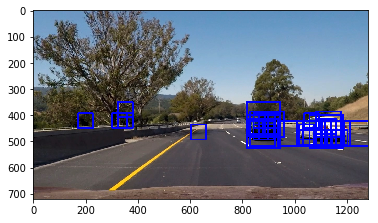

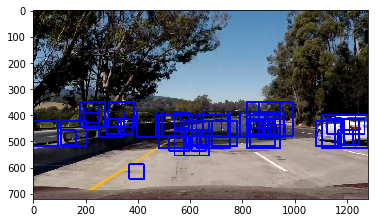

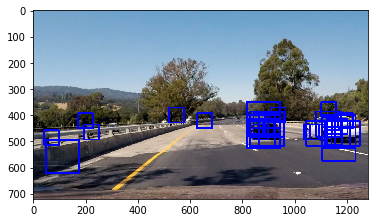

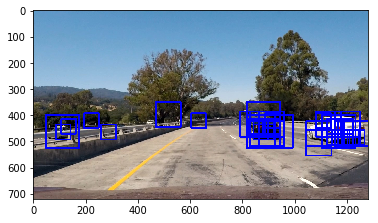

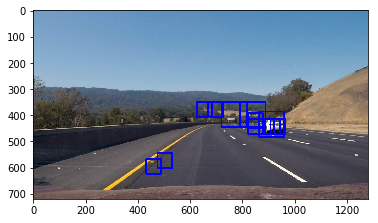

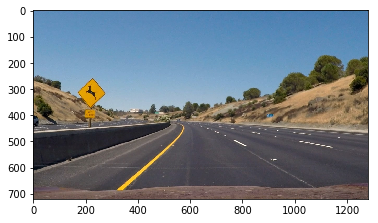

In [69]:
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
# img = img.astype(np.float32)/255

ystart = 350
ystop = 656
scales = [ 0.9, 1.5, 2.0]

# img = mpimg.imread('test_images/test3.jpg')
# box_list, draw_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
# plt.imshow(draw_img)
# plt.show()

test_imgs = glob.glob('test_images/*.jpg')
for image in test_imgs:
    img = mpimg.imread(image)
    bbox_list = []
    draw_img = img
    for scale in scales:
        box_list, draw_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bbox_list = bbox_list + box_list
    ndraw_img = img
    for box_c in bbox_list:
        xbox_left, ybox_left = box_c[0]
        xbox_right, ybox_right = box_c[1]
        ndraw_img = cv2.rectangle(ndraw_img,(xbox_left, ybox_left),(xbox_right, ybox_right),(0,0,255),6)
    plt.imshow(ndraw_img)
    plt.show()

/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


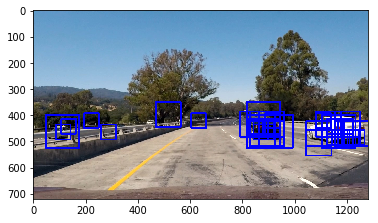

In [81]:
test_imgs = glob.glob('test_images/test1.jpg')

img = mpimg.imread('test_images/test1.jpg')

bbox_list = []
draw_img = img
for scale in scales:
    box_list, draw_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bbox_list = bbox_list + box_list
ndraw_img = img
for box_c in bbox_list:
    xbox_left, ybox_left = box_c[0]
    xbox_right, ybox_right = box_c[1]
    ndraw_img = cv2.rectangle(ndraw_img,(xbox_left, ybox_left),(xbox_right, ybox_right),(0,0,255),6)
plt.imshow(ndraw_img)
plt.show()

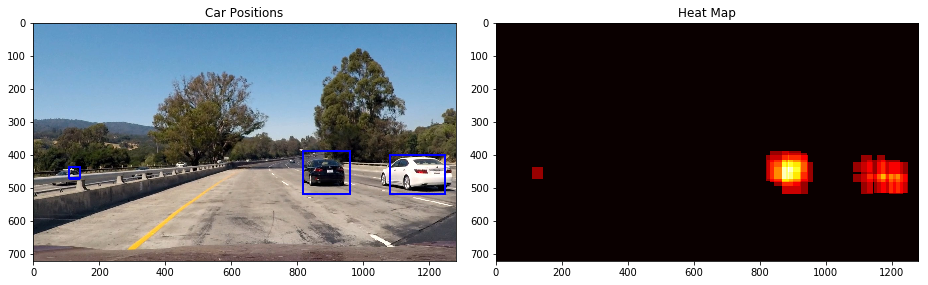

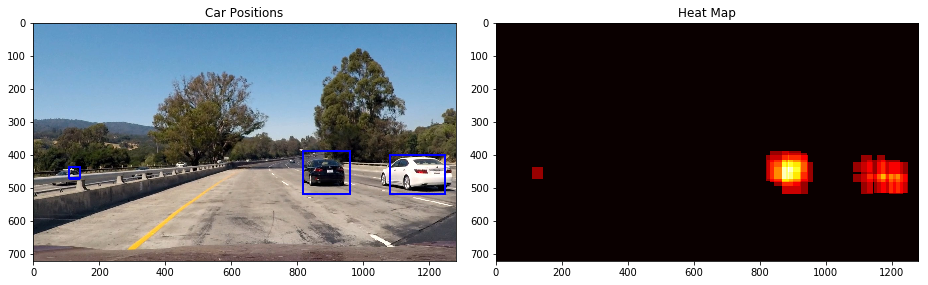

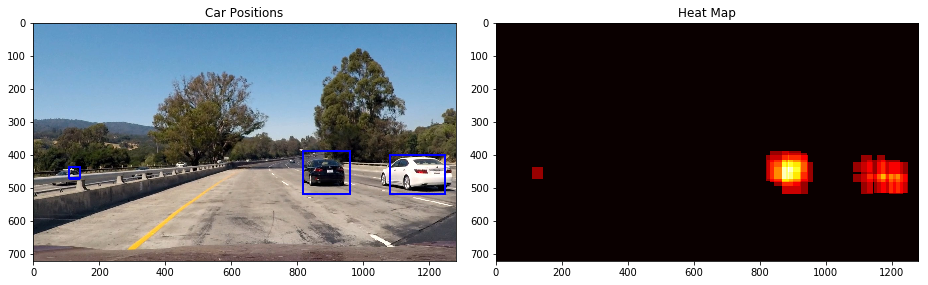

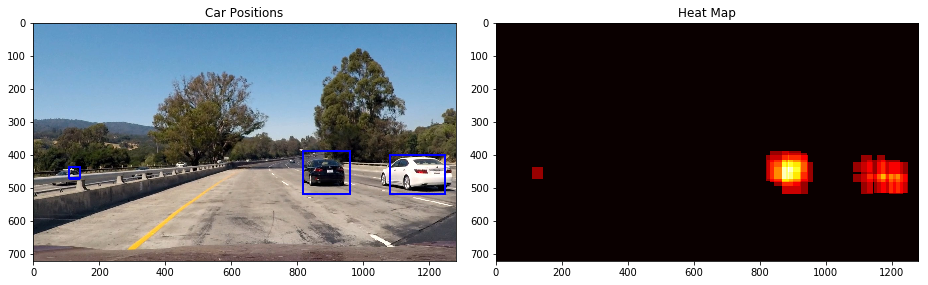

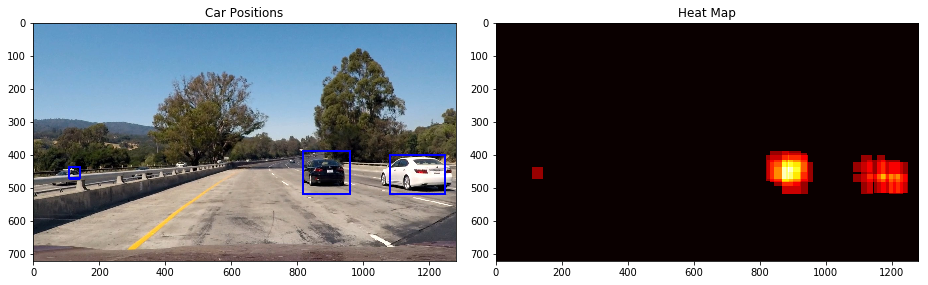

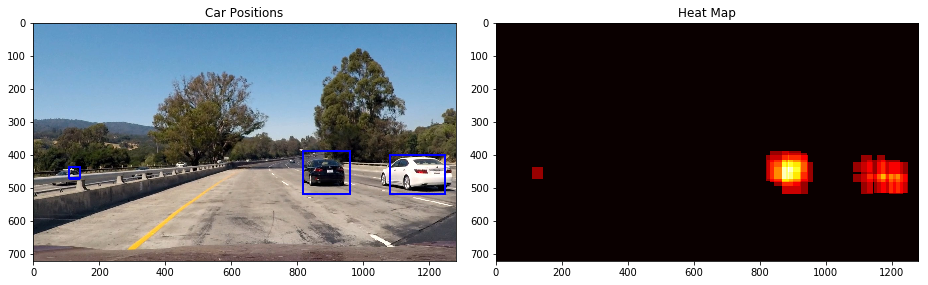

In [114]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        xbox_left, ybox_left = box[0]
        xbox_right, ybox_right = box[1]
        heatmap[ybox_left:ybox_right, xbox_left:xbox_right] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
# box_list = pickle.load( open( "bbox_pickle.p", "rb" ))
test_imgs = glob.glob('test_images/*.jpg')
for img in test_imgs:
    image = mpimg.imread(img)
    # Read in image similar to one shown above 
    image = mpimg.imread('test_images/test1.jpg')
    bbox_list = []
    draw_img = image
    for scale in scales:
        box_list, draw_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bbox_list = bbox_list + box_list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)



    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure(figsize=(13,10))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()


## Pipeline

In [115]:
def process_image(img):
    scales = [ 0.9, 1.5, 2.0]
#     box_list, d_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bbox_list = []
    for scale in scales:
        box_list, d_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bbox_list = bbox_list + box_list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

In [134]:
from collections import deque
history = deque(maxlen = 8)
def process_image1(img):
    scales = [ 0.9, 1.5, 2.0]
#     box_list, d_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bbox_list = []
    for scale in scales:
        box_list, d_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bbox_list = bbox_list + box_list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
    history.append(heat)
    heat_avg = np.average(np.array(history), axis=0)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat_avg,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
#     draw_img[:,:,0] = heatmap

    return draw_img

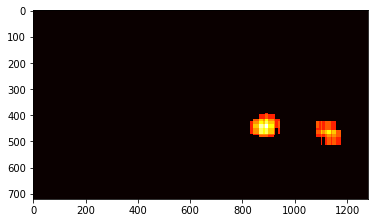

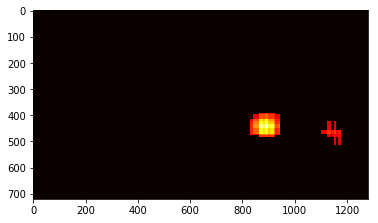

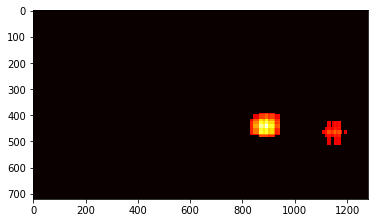

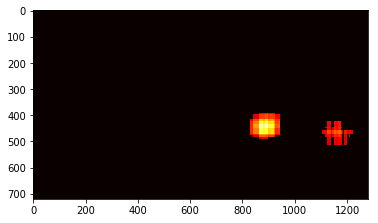

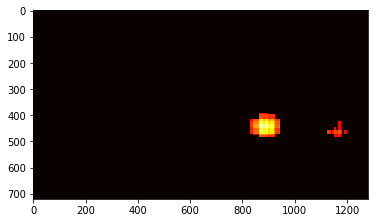

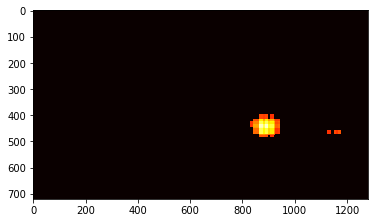

In [130]:
# Don't run this block if attempting project video
test_imgs = glob.glob('test_images/*.jpg')
for img in test_imgs:
    image = mpimg.imread(img)
    heatmap = process_image1(image)
    plt.imshow(heatmap, cmap='hot')
    plt.show()

In [135]:
# Import everything needed to edit/save/watch video clips
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
test_output = 'test_video_out7.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('project_video.mp4').subclip(40,45)
test_clip = clip3.fl_image(process_image1)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_video_out7.mp4
[MoviePy] Writing video test_video_out7.mp4






  0%|          | 0/126 [00:00<?, ?it/s]



  1%|          | 1/126 [00:01<02:47,  1.34s/it]



  2%|▏         | 2/126 [00:02<02:45,  1.34s/it]



  2%|▏         | 3/126 [00:04<02:45,  1.34s/it]



  3%|▎         | 4/126 [00:05<02:43,  1.34s/it]



  4%|▍         | 5/126 [00:06<02:42,  1.35s/it]



  5%|▍         | 6/126 [00:08<02:41,  1.35s/it]



  6%|▌         | 7/126 [00:09<02:40,  1.35s/it]



  6%|▋         | 8/126 [00:10<02:39,  1.36s/it]



  7%|▋         | 9/126 [00:12<02:39,  1.36s/it]



  8%|▊         | 10/126 [00:13<02:37,  1.36s/it]



  9%|▊         | 11/126 [00:15<02:36,  1.36s/it]



 10%|▉         | 12/126 [00:16<02:35,  1.37s/it]



 10%|█         | 13/126 [00:17<02:34,  1.36s/it]



 11%|█         | 14/126 [00:19<02:32,  1.36s/it]



 12%|█▏        | 15/126 [00:20<02:31,  1.36s/it]



 13%|█▎        | 16/126 [00:21<02:30,  1.37s/it]



 13%|█▎        | 17/126 [00:23<02:29,  1.37s/it]



 14%|█▍        | 18/126 [00:24<02:27,  1.37s/it]



 15%|█▌        | 19/126 [0

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out7.mp4 

CPU times: user 7min 6s, sys: 20.4 s, total: 7min 26s
Wall time: 2min 55s


In [126]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_clip))

In [136]:
challenge_output = 'project_video_out_full_4.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip2 = VideoFileClip('project_video.mp4')
challenge_clip = clip2.fl_image(process_image1)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video project_video_out_full_4.mp4
[MoviePy] Writing video project_video_out_full_4.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:01<35:22,  1.68s/it]



  0%|          | 2/1261 [00:03<33:02,  1.57s/it]



  0%|          | 3/1261 [00:04<32:41,  1.56s/it]



  0%|          | 4/1261 [00:06<31:58,  1.53s/it]



  0%|          | 5/1261 [00:07<31:21,  1.50s/it]



  0%|          | 6/1261 [00:08<30:52,  1.48s/it]



  1%|          | 7/1261 [00:10<31:42,  1.52s/it]



  1%|          | 8/1261 [00:16<42:32,  2.04s/it]



  1%|          | 9/1261 [00:17<40:59,  1.96s/it]



  1%|          | 10/1261 [00:19<39:40,  1.90s/it]



  1%|          | 11/1261 [00:20<38:36,  1.85s/it]



  1%|          | 12/1261 [00:21<37:43,  1.81s/it]



  1%|          | 13/1261 [00:25<40:48,  1.96s/it]



  1%|          | 14/1261 [00:28<42:07,  2.03s/it]



  1%|          | 15/1261 [00:29<41:12,  1.98s/it]



  1%|▏         | 16/1261 [00:31<40:27,  1.95s/it]



  1%|▏         | 17/1261 [00:35<43:14,  2.09s/it]



  1%|▏         | 18/1261 [00:37<42:36,  2.06s/it]



  2%|▏ 

 10%|▉         | 125/1261 [04:40<42:28,  2.24s/it]



 10%|▉         | 126/1261 [04:41<42:18,  2.24s/it]



 10%|█         | 127/1261 [04:43<42:09,  2.23s/it]



 10%|█         | 128/1261 [04:44<42:00,  2.22s/it]



 10%|█         | 129/1261 [04:46<41:51,  2.22s/it]



 10%|█         | 130/1261 [04:47<41:43,  2.21s/it]



 10%|█         | 131/1261 [04:49<41:34,  2.21s/it]



 10%|█         | 132/1261 [04:50<41:25,  2.20s/it]



 11%|█         | 133/1261 [04:52<41:16,  2.20s/it]



 11%|█         | 134/1261 [04:53<41:08,  2.19s/it]



 11%|█         | 135/1261 [04:54<40:59,  2.18s/it]



 11%|█         | 136/1261 [04:56<40:51,  2.18s/it]



 11%|█         | 137/1261 [04:57<40:43,  2.17s/it]



 11%|█         | 138/1261 [04:59<40:35,  2.17s/it]



 11%|█         | 139/1261 [05:00<40:28,  2.16s/it]



 11%|█         | 140/1261 [05:02<40:20,  2.16s/it]



 11%|█         | 141/1261 [05:03<40:13,  2.16s/it]



 11%|█▏        | 142/1261 [05:05<40:06,  2.15s/it]



 11%|█▏        | 143/1261 [0

 20%|█▉        | 249/1261 [07:55<32:11,  1.91s/it]



 20%|█▉        | 250/1261 [07:57<32:10,  1.91s/it]



 20%|█▉        | 251/1261 [07:59<32:08,  1.91s/it]



 20%|█▉        | 252/1261 [08:01<32:06,  1.91s/it]



 20%|██        | 253/1261 [08:02<32:03,  1.91s/it]



 20%|██        | 254/1261 [08:04<32:00,  1.91s/it]



 20%|██        | 255/1261 [08:06<31:57,  1.91s/it]



 20%|██        | 256/1261 [08:07<31:54,  1.90s/it]



 20%|██        | 257/1261 [08:09<31:51,  1.90s/it]



 20%|██        | 258/1261 [08:10<31:47,  1.90s/it]



 21%|██        | 259/1261 [08:12<31:44,  1.90s/it]



 21%|██        | 260/1261 [08:13<31:41,  1.90s/it]



 21%|██        | 261/1261 [08:15<31:38,  1.90s/it]



 21%|██        | 262/1261 [08:17<31:35,  1.90s/it]



 21%|██        | 263/1261 [08:18<31:31,  1.90s/it]



 21%|██        | 264/1261 [08:20<31:28,  1.89s/it]



 21%|██        | 265/1261 [08:21<31:25,  1.89s/it]



 21%|██        | 266/1261 [08:23<31:22,  1.89s/it]



 21%|██        | 267/1261 [0

 30%|██▉       | 373/1261 [11:14<26:45,  1.81s/it]



 30%|██▉       | 374/1261 [11:16<26:43,  1.81s/it]



 30%|██▉       | 375/1261 [11:17<26:41,  1.81s/it]



 30%|██▉       | 376/1261 [11:19<26:39,  1.81s/it]



 30%|██▉       | 377/1261 [11:21<26:37,  1.81s/it]



 30%|██▉       | 378/1261 [11:22<26:34,  1.81s/it]



 30%|███       | 379/1261 [11:24<26:33,  1.81s/it]



 30%|███       | 380/1261 [11:26<26:30,  1.81s/it]



 30%|███       | 381/1261 [11:27<26:28,  1.81s/it]



 30%|███       | 382/1261 [11:29<26:27,  1.81s/it]



 30%|███       | 383/1261 [11:31<26:25,  1.81s/it]



 30%|███       | 384/1261 [11:34<26:25,  1.81s/it]



 31%|███       | 385/1261 [11:36<26:24,  1.81s/it]



 31%|███       | 386/1261 [11:38<26:23,  1.81s/it]



 31%|███       | 387/1261 [11:40<26:21,  1.81s/it]



 31%|███       | 388/1261 [11:42<26:20,  1.81s/it]



 31%|███       | 389/1261 [11:44<26:19,  1.81s/it]



 31%|███       | 390/1261 [11:46<26:17,  1.81s/it]



 31%|███       | 391/1261 [1

 39%|███▉      | 497/1261 [14:20<22:03,  1.73s/it]



 39%|███▉      | 498/1261 [14:22<22:00,  1.73s/it]



 40%|███▉      | 499/1261 [14:23<21:58,  1.73s/it]



 40%|███▉      | 500/1261 [14:24<21:56,  1.73s/it]



 40%|███▉      | 501/1261 [14:26<21:54,  1.73s/it]



 40%|███▉      | 502/1261 [14:27<21:52,  1.73s/it]



 40%|███▉      | 503/1261 [14:29<21:49,  1.73s/it]



 40%|███▉      | 504/1261 [14:30<21:47,  1.73s/it]



 40%|████      | 505/1261 [14:32<21:45,  1.73s/it]



 40%|████      | 506/1261 [14:33<21:43,  1.73s/it]



 40%|████      | 507/1261 [14:35<21:41,  1.73s/it]



 40%|████      | 508/1261 [14:36<21:39,  1.73s/it]



 40%|████      | 509/1261 [14:37<21:37,  1.72s/it]



 40%|████      | 510/1261 [14:39<21:34,  1.72s/it]



 41%|████      | 511/1261 [14:40<21:32,  1.72s/it]



 41%|████      | 512/1261 [14:42<21:30,  1.72s/it]



 41%|████      | 513/1261 [14:43<21:28,  1.72s/it]



 41%|████      | 514/1261 [14:44<21:26,  1.72s/it]



 41%|████      | 515/1261 [1

 49%|████▉     | 621/1261 [17:15<17:46,  1.67s/it]



 49%|████▉     | 622/1261 [17:16<17:44,  1.67s/it]



 49%|████▉     | 623/1261 [17:18<17:42,  1.67s/it]



 49%|████▉     | 624/1261 [17:19<17:41,  1.67s/it]



 50%|████▉     | 625/1261 [17:20<17:39,  1.67s/it]



 50%|████▉     | 626/1261 [17:22<17:37,  1.66s/it]



 50%|████▉     | 627/1261 [17:23<17:35,  1.66s/it]



 50%|████▉     | 628/1261 [17:25<17:33,  1.66s/it]



 50%|████▉     | 629/1261 [17:26<17:31,  1.66s/it]



 50%|████▉     | 630/1261 [17:27<17:29,  1.66s/it]



 50%|█████     | 631/1261 [17:29<17:27,  1.66s/it]



 50%|█████     | 632/1261 [17:30<17:25,  1.66s/it]



 50%|█████     | 633/1261 [17:31<17:23,  1.66s/it]



 50%|█████     | 634/1261 [17:33<17:21,  1.66s/it]



 50%|█████     | 635/1261 [17:34<17:19,  1.66s/it]



 50%|█████     | 636/1261 [17:36<17:17,  1.66s/it]



 51%|█████     | 637/1261 [17:37<17:15,  1.66s/it]



 51%|█████     | 638/1261 [17:38<17:14,  1.66s/it]



 51%|█████     | 639/1261 [1

 59%|█████▉    | 745/1261 [20:10<13:58,  1.62s/it]



 59%|█████▉    | 746/1261 [20:11<13:56,  1.62s/it]



 59%|█████▉    | 747/1261 [20:13<13:54,  1.62s/it]



 59%|█████▉    | 748/1261 [20:14<13:53,  1.62s/it]



 59%|█████▉    | 749/1261 [20:16<13:51,  1.62s/it]



 59%|█████▉    | 750/1261 [20:17<13:49,  1.62s/it]



 60%|█████▉    | 751/1261 [20:18<13:47,  1.62s/it]



 60%|█████▉    | 752/1261 [20:20<13:46,  1.62s/it]



 60%|█████▉    | 753/1261 [20:21<13:44,  1.62s/it]



 60%|█████▉    | 754/1261 [20:23<13:42,  1.62s/it]



 60%|█████▉    | 755/1261 [20:24<13:40,  1.62s/it]



 60%|█████▉    | 756/1261 [20:25<13:38,  1.62s/it]



 60%|██████    | 757/1261 [20:27<13:37,  1.62s/it]



 60%|██████    | 758/1261 [20:28<13:35,  1.62s/it]



 60%|██████    | 759/1261 [20:30<13:33,  1.62s/it]



 60%|██████    | 760/1261 [20:31<13:31,  1.62s/it]



 60%|██████    | 761/1261 [20:32<13:30,  1.62s/it]



 60%|██████    | 762/1261 [20:34<13:28,  1.62s/it]



 61%|██████    | 763/1261 [2

 69%|██████▉   | 869/1261 [23:03<10:24,  1.59s/it]



 69%|██████▉   | 870/1261 [23:05<10:22,  1.59s/it]



 69%|██████▉   | 871/1261 [23:06<10:20,  1.59s/it]



 69%|██████▉   | 872/1261 [23:07<10:19,  1.59s/it]



 69%|██████▉   | 873/1261 [23:09<10:17,  1.59s/it]



 69%|██████▉   | 874/1261 [23:10<10:15,  1.59s/it]



 69%|██████▉   | 875/1261 [23:12<10:14,  1.59s/it]



 69%|██████▉   | 876/1261 [23:13<10:12,  1.59s/it]



 70%|██████▉   | 877/1261 [23:14<10:10,  1.59s/it]



 70%|██████▉   | 878/1261 [23:16<10:09,  1.59s/it]



 70%|██████▉   | 879/1261 [23:17<10:07,  1.59s/it]



 70%|██████▉   | 880/1261 [23:19<10:05,  1.59s/it]



 70%|██████▉   | 881/1261 [23:20<10:04,  1.59s/it]



 70%|██████▉   | 882/1261 [23:21<10:02,  1.59s/it]



 70%|███████   | 883/1261 [23:23<10:00,  1.59s/it]



 70%|███████   | 884/1261 [23:24<09:59,  1.59s/it]



 70%|███████   | 885/1261 [23:26<09:57,  1.59s/it]



 70%|███████   | 886/1261 [23:27<09:55,  1.59s/it]



 70%|███████   | 887/1261 [2

 79%|███████▊  | 993/1261 [25:55<06:59,  1.57s/it]



 79%|███████▉  | 994/1261 [25:56<06:58,  1.57s/it]



 79%|███████▉  | 995/1261 [25:57<06:56,  1.57s/it]



 79%|███████▉  | 996/1261 [25:59<06:54,  1.57s/it]



 79%|███████▉  | 997/1261 [26:00<06:53,  1.57s/it]



 79%|███████▉  | 998/1261 [26:02<06:51,  1.57s/it]



 79%|███████▉  | 999/1261 [26:04<06:50,  1.57s/it]



 79%|███████▉  | 1000/1261 [26:05<06:48,  1.57s/it]



 79%|███████▉  | 1001/1261 [26:07<06:47,  1.57s/it]



 79%|███████▉  | 1002/1261 [26:08<06:45,  1.57s/it]



 80%|███████▉  | 1003/1261 [26:10<06:43,  1.57s/it]



 80%|███████▉  | 1004/1261 [26:11<06:42,  1.57s/it]



 80%|███████▉  | 1005/1261 [26:12<06:40,  1.57s/it]



 80%|███████▉  | 1006/1261 [26:14<06:39,  1.57s/it]



 80%|███████▉  | 1007/1261 [26:15<06:37,  1.56s/it]



 80%|███████▉  | 1008/1261 [26:17<06:35,  1.56s/it]



 80%|████████  | 1009/1261 [26:18<06:34,  1.56s/it]



 80%|████████  | 1010/1261 [26:20<06:32,  1.56s/it]



 80%|████████  | 

 88%|████████▊ | 1115/1261 [28:58<03:47,  1.56s/it]



 89%|████████▊ | 1116/1261 [28:59<03:46,  1.56s/it]



 89%|████████▊ | 1117/1261 [29:00<03:44,  1.56s/it]



 89%|████████▊ | 1118/1261 [29:02<03:42,  1.56s/it]



 89%|████████▊ | 1119/1261 [29:03<03:41,  1.56s/it]



 89%|████████▉ | 1120/1261 [29:05<03:39,  1.56s/it]



 89%|████████▉ | 1121/1261 [29:06<03:38,  1.56s/it]



 89%|████████▉ | 1122/1261 [29:08<03:36,  1.56s/it]



 89%|████████▉ | 1123/1261 [29:09<03:35,  1.56s/it]



 89%|████████▉ | 1124/1261 [29:11<03:33,  1.56s/it]



 89%|████████▉ | 1125/1261 [29:12<03:31,  1.56s/it]



 89%|████████▉ | 1126/1261 [29:14<03:30,  1.56s/it]



 89%|████████▉ | 1127/1261 [29:15<03:28,  1.56s/it]



 89%|████████▉ | 1128/1261 [29:17<03:27,  1.56s/it]



 90%|████████▉ | 1129/1261 [29:19<03:25,  1.56s/it]



 90%|████████▉ | 1130/1261 [29:21<03:24,  1.56s/it]



 90%|████████▉ | 1131/1261 [29:23<03:22,  1.56s/it]



 90%|████████▉ | 1132/1261 [29:25<03:21,  1.56s/it]



 90%|█████

 98%|█████████▊| 1237/1261 [31:56<00:37,  1.55s/it]



 98%|█████████▊| 1238/1261 [31:58<00:35,  1.55s/it]



 98%|█████████▊| 1239/1261 [31:59<00:34,  1.55s/it]



 98%|█████████▊| 1240/1261 [32:01<00:32,  1.55s/it]



 98%|█████████▊| 1241/1261 [32:03<00:30,  1.55s/it]



 98%|█████████▊| 1242/1261 [32:05<00:29,  1.55s/it]



 99%|█████████▊| 1243/1261 [32:07<00:27,  1.55s/it]



 99%|█████████▊| 1244/1261 [32:10<00:26,  1.55s/it]



 99%|█████████▊| 1245/1261 [32:11<00:24,  1.55s/it]



 99%|█████████▉| 1246/1261 [32:13<00:23,  1.55s/it]



 99%|█████████▉| 1247/1261 [32:15<00:21,  1.55s/it]



 99%|█████████▉| 1248/1261 [32:17<00:20,  1.55s/it]



 99%|█████████▉| 1249/1261 [32:19<00:18,  1.55s/it]



 99%|█████████▉| 1250/1261 [32:20<00:17,  1.55s/it]



 99%|█████████▉| 1251/1261 [32:21<00:15,  1.55s/it]



 99%|█████████▉| 1252/1261 [32:23<00:13,  1.55s/it]



 99%|█████████▉| 1253/1261 [32:24<00:12,  1.55s/it]



 99%|█████████▉| 1254/1261 [32:26<00:10,  1.55s/it]



100%|█████

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_full_4.mp4 

CPU times: user 1h 17min 32s, sys: 4min 1s, total: 1h 21min 34s
Wall time: 32min 36s
